In [9]:
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

import datetime
from easydict import EasyDict
import pyupbit

### csv 불러와서 DataFrame 에 넣기

In [13]:
data_root_path = '../data'
data_folders = glob(data_root_path + '/*')
merge_df = pd.DataFrame()

use_csv = True

if use_csv == True :
    for data_folder in tqdm(data_folders) :
        data_csvs = glob(data_folder + '/*.csv')

        for data_csv in data_csvs :
            df = pd.read_csv(data_csv).drop(columns=["Unnamed: 0"])
            merge_df = pd.concat([merge_df, df], ignore_index=True)
    merge_df
    
else :
    options = {
    'ticker' : 'KRW-BTC',
    'interval' : 'minute10',
    'to' : datetime.datetime.now().strftime('%Y-%m-%d %H:%M'),
    'count' : 100000
    }

    args = EasyDict(options)

    df = pyupbit.get_ohlcv(ticker=args.ticker, interval=args.interval, to=args.to, count=args.count)
    merge_df = df.reset_index(drop=True)
    merge_df


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


In [15]:
merge_df

,open,high,low,close,volume,value
0,4670000.0,4676000.0,4659000.0,4674000.0,0.217243,1.013624e+06
1,4674000.0,4676000.0,4662000.0,4663000.0,0.372060,1.735117e+06
2,4670000.0,4670000.0,4662000.0,4669000.0,0.051731,2.413295e+05
3,4666000.0,4668000.0,4657000.0,4657000.0,0.025973,1.211313e+05
4,4656000.0,4662000.0,4651000.0,4651000.0,0.021728,1.011398e+05
...,...,...,...,...,...,...
215275,74604000.0,74692000.0,74374000.0,74557000.0,84.096223,6.267920e+09
215276,74550000.0,74657000.0,74495000.0,74634000.0,54.106478,4.036582e+09
215277,74634000.0,74800000.0,74555000.0,74574000.0,58.969552,4.402763e+09
215278,74578000.0,74689000.0,74540000.0,74542000.0,43.026878,3.209534e+09


### date, value 제거

In [17]:
# drop_columns = ['date', 'value']

# dropped_merge_df = merge_df.drop(columns=drop_columns)
dropped_merge_df = merge_df

###  average price 구해서 feature 추가

In [18]:
dropped_merge_df['avg_price'] = (dropped_merge_df['high'] + 
                                 dropped_merge_df['low'] + 
                                dropped_merge_df['open'] + 
                                dropped_merge_df['close'] ) // 4
dropped_merge_df

,open,high,low,close,volume,value,avg_price
0,4670000.0,4676000.0,4659000.0,4674000.0,0.217243,1.013624e+06,4669750.0
1,4674000.0,4676000.0,4662000.0,4663000.0,0.372060,1.735117e+06,4668750.0
2,4670000.0,4670000.0,4662000.0,4669000.0,0.051731,2.413295e+05,4667750.0
3,4666000.0,4668000.0,4657000.0,4657000.0,0.025973,1.211313e+05,4662000.0
4,4656000.0,4662000.0,4651000.0,4651000.0,0.021728,1.011398e+05,4655000.0
...,...,...,...,...,...,...,...
215275,74604000.0,74692000.0,74374000.0,74557000.0,84.096223,6.267920e+09,74556750.0
215276,74550000.0,74657000.0,74495000.0,74634000.0,54.106478,4.036582e+09,74584000.0
215277,74634000.0,74800000.0,74555000.0,74574000.0,58.969552,4.402763e+09,74640750.0
215278,74578000.0,74689000.0,74540000.0,74542000.0,43.026878,3.209534e+09,74587250.0


### 10분 뒤 가격을 feature 추가
- close 기준
- target(label)이 될 예정
- 마지막 1행은 after10이 없으므로 삭제

In [19]:
after10 = np.zeros_like(dropped_merge_df['close'])
for i in range(len(dropped_merge_df['close']) - 1) :
        after10[i] = dropped_merge_df['close'][i + 1]
        
dropped_merge_df['after10'] = after10
dropped_merge_df = dropped_merge_df.drop([dropped_merge_df.index[-1]])
dropped_merge_df

,open,high,low,close,volume,value,avg_price,after10
0,4670000.0,4676000.0,4659000.0,4674000.0,0.217243,1.013624e+06,4669750.0,4663000.0
1,4674000.0,4676000.0,4662000.0,4663000.0,0.372060,1.735117e+06,4668750.0,4669000.0
2,4670000.0,4670000.0,4662000.0,4669000.0,0.051731,2.413295e+05,4667750.0,4657000.0
3,4666000.0,4668000.0,4657000.0,4657000.0,0.025973,1.211313e+05,4662000.0,4651000.0
4,4656000.0,4662000.0,4651000.0,4651000.0,0.021728,1.011398e+05,4655000.0,4656000.0
...,...,...,...,...,...,...,...,...
215274,74701000.0,75120000.0,74547000.0,74604000.0,174.254459,1.304821e+10,74743000.0,74557000.0
215275,74604000.0,74692000.0,74374000.0,74557000.0,84.096223,6.267920e+09,74556750.0,74634000.0
215276,74550000.0,74657000.0,74495000.0,74634000.0,54.106478,4.036582e+09,74584000.0,74574000.0
215277,74634000.0,74800000.0,74555000.0,74574000.0,58.969552,4.402763e+09,74640750.0,74542000.0


### Data normalization

In [20]:
norm = MinMaxScaler()
norm_np = norm.fit_transform(dropped_merge_df)
norm_df = pd.DataFrame(norm_np, columns=list(dropped_merge_df.columns))
norm_df

,open,high,low,close,volume,value,avg_price,after10
0,0.014033,0.014027,0.014034,0.014059,0.000061,0.000011,0.014037,0.013919
1,0.014085,0.014027,0.014072,0.013919,0.000105,0.000019,0.014024,0.013995
2,0.014033,0.013951,0.014072,0.013995,0.000015,0.000003,0.014012,0.013842
3,0.013982,0.013925,0.014008,0.013842,0.000007,0.000001,0.013938,0.013765
4,0.013854,0.013849,0.013932,0.013765,0.000006,0.000001,0.013849,0.013829
...,...,...,...,...,...,...,...,...
215274,0.909090,0.912342,0.908120,0.907848,0.048951,0.140746,0.909874,0.907247
215275,0.907850,0.906884,0.905907,0.907247,0.023624,0.067610,0.907493,0.908231
215276,0.907160,0.906437,0.907455,0.908231,0.015199,0.043541,0.907841,0.907464
215277,0.908233,0.908261,0.908222,0.907464,0.016565,0.047491,0.908567,0.907055


### Data split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    norm_df.drop('after10', 1), 
    norm_df['after10'], 
    test_size=0.1, 
    random_state=0, 
    shuffle=False)

print(x_train.shape, y_train.shape)
print(x_train)
print(y_train)

(193751, 7) (193751,)
            open      high       low     close    volume     value  avg_price
0       0.014033  0.014027  0.014034  0.014059  0.000061  0.000011   0.014037
1       0.014085  0.014027  0.014072  0.013919  0.000105  0.000019   0.014024
2       0.014033  0.013951  0.014072  0.013995  0.000015  0.000003   0.014012
3       0.013982  0.013925  0.014008  0.013842  0.000007  0.000001   0.013938
4       0.013854  0.013849  0.013932  0.013765  0.000006  0.000001   0.013849
...          ...       ...       ...       ...       ...       ...        ...
193746  0.496447  0.495664  0.496207  0.496306  0.008322  0.013551   0.496436
193747  0.496319  0.495792  0.496322  0.496702  0.006949  0.011320   0.496564
193748  0.496715  0.495549  0.495746  0.495156  0.008271  0.013451   0.496072
193749  0.495169  0.494542  0.495657  0.495527  0.005174  0.008408   0.495503
193750  0.495578  0.495141  0.495567  0.495974  0.006810  0.011069   0.495845

[193751 rows x 7 columns]
0         0.013

### Tensorflow Dataset 활용하여 시퀀스 데이터셋 구성
[출처:https://teddylee777.github.io/tensorflow/lstm-stock-forecast]

- window_size : 과거 몇 개의 데이터를 기준으로 다음에 오는 데이터를 예측할 것인가를 결정
    - 만약 window_size=6 이면, 6개(1시간 치 데이터)를 기준으로 다음에 10분 후에 나오는 데이터의 after10을 예측함

In [22]:
def windowed_dataset(data, label, window_size, batch_size, shuffle):

    ds_x = tf.data.Dataset.from_tensor_slices(data)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices(label[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE = 12
BATCH_SIZE = 128

train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [23]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
#     print(data[0])
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')
    print(data[1])

데이터셋(X) 구성(batch_size, window_size, feature갯수): (128, 12, 7)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (128,)
tf.Tensor(
[0.01821319 0.01661554 0.01743354 0.01614264 0.0167817  0.01730573
 0.01669223 0.01685838 0.01629601 0.0176636  0.0185455  0.01825153
 0.01641104 0.01731851 0.01762526 0.01754857 0.01858384 0.01743354
 0.0168456  0.0165772  0.01694785 0.01882669 0.01841769 0.01662832
 0.01699898 0.01554192 0.01822597 0.01872444 0.01716513 0.01774029
 0.01768916 0.01627045 0.01892894 0.01844325 0.01738241 0.0174591
 0.01818763 0.01501789 0.01724182 0.01504346 0.01701176 0.01736963
 0.01768916 0.01690951 0.0176636  0.01581033 0.01683282 0.0185455
 0.01680726 0.01682004 0.01881391 0.01739519 0.01863497 0.01763804
 0.01414877 0.01781697 0.01593814 0.01665389 0.01609151 0.01754857
 0.01919734 0.0182771  0.01869888 0.01547802 0.0185455  0.01851994
 0.01707566 0.01867331 0.01756135 0.01790644 0.01680726 0.01621933
 0.01515849 0.01871166 0.01676892 0.0169862  0.01835378 0.01756135
 0.0

### Model Define

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [36]:
def get_model(input_shape):
    input = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=0.3))(input)
    x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh', dropout=0.3))(x)
    x = Bidirectional(LSTM(32, return_sequences=True, activation='tanh', dropout=0.3))(x)
    x = GlobalAveragePooling1D()(x)
    output = Dense(1)(x)
    model = Model(input, output)
    return model

feature_n = 7
model = get_model((WINDOW_SIZE, feature_n))
model

# model = Sequential([
#     # 1차원 feature map 생성
#     Conv1D(filters=32, kernel_size=5,
#            padding="causal",
#            activation="relu",
#            input_shape=[WINDOW_SIZE, 1]),
#     # LSTM
#     LSTM(16, activation='tanh'),
#     Dense(16, activation="relu"),
#     Dense(1),
# ])

### model compile

In [37]:
loss = Huber()
optimizer = Adam(0.0001)
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

earlystopping = EarlyStopping(monitor='val_loss', patience=10)

filename = os.path.join('./checkpoints/BiLSTM', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

### Train

In [38]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=150, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/150
1514/1514 [==============================] - 60s 36ms/step - loss: 3.5645e-05 - mse: 7.1291e-05 - val_loss: 0.0017 - val_mse: 0.0035

Epoch 00001: val_loss improved from inf to 0.00175, saving model to ./checkpoints/BiLSTM\ckeckpointer.ckpt
Epoch 2/150
1514/1514 [==============================] - 52s 35ms/step - loss: 5.8578e-05 - mse: 1.1716e-04 - val_loss: 9.7216e-04 - val_mse: 0.0019

Epoch 00002: val_loss improved from 0.00175 to 0.00097, saving model to ./checkpoints/BiLSTM\ckeckpointer.ckpt
Epoch 3/150
1514/1514 [==============================] - 53s 35ms/step - loss: 4.3852e-05 - mse: 8.7704e-05 - val_loss: 0.0013 - val_mse: 0.0026

Epoch 00003: val_loss did not improve from 0.00097
Epoch 4/150
1514/1514 [==============================] - 53s 35ms/step - loss: 4.9669e-05 - mse: 9.9339e-05 - val_loss: 0.0014 - val_mse: 0.0029

Epoch 00004: val_loss did not improve from 0.00097
Epoch 5/150
1514/1514 [==============================] - 53s 35ms/step - loss: 3.6660e-05 - 

In [39]:
history

In [40]:
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)


(21516, 1)
(21516, 1)


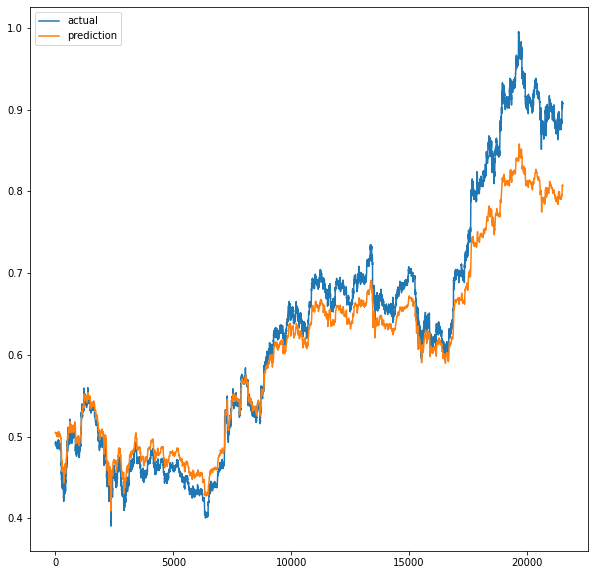

In [41]:
# BiLSTM
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

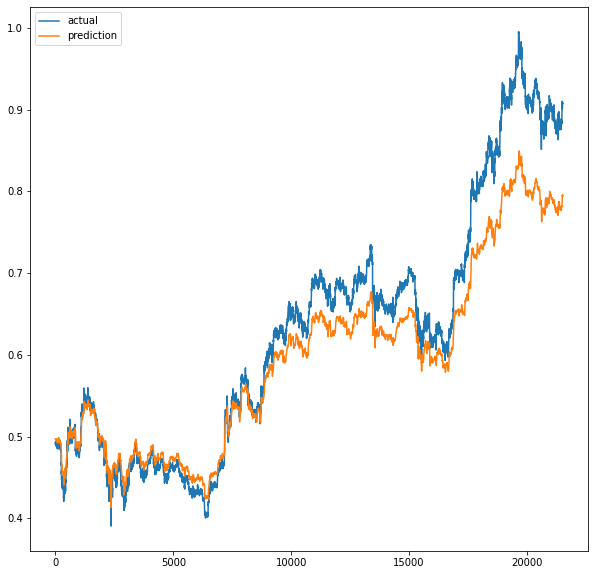

In [16]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()